## Karpathy micrograd Zero to Hero video series
### Video 1

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

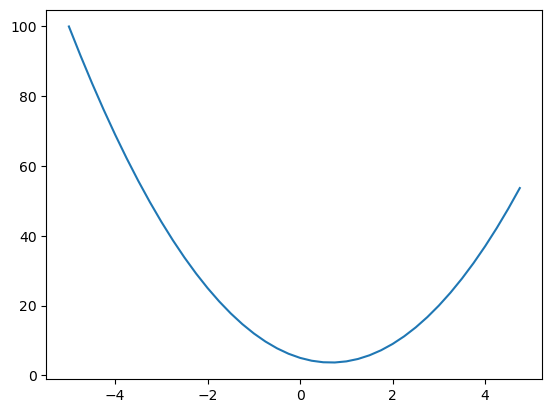

In [6]:
plt.plot(xs, ys)

In [7]:
# derivative
h = 0.000001
x = 3.0
(f(x + h) - f(x))/h

14.000003002223593

In [8]:
h = 0.000001
x = -3.0
(f(x + h) - f(x))/h

-21.999997002808414

In [9]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [10]:
# get more complex functions
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [11]:
# get more complex functions
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [12]:
# get more complex functions
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


### Graphviz to draw the NN

In [13]:
from graphviz import Digraph

In [14]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### Let's go to Neural Networks
Massive functions

In [180]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # print better
    def __repr__(self):
        # return f"<Value(data={self.data}), {self._prev}, {self._op}>"
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        # if other is a number like 2.4 create Value(other)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # closure : retains outer scope, remembers self and other
        # local grad * global grad
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward # store the function to be called later not call the function now

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        # closure
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out
    
    # python will check x * 2 if 2 * x fails
    def __rmul__(self, other): # other * self
        return self * other
    
    def __radd__(self, other): # other + self 
        return self + other # ex: 2 + Value(3.2)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            # d(e^x)/dx = e^x
            self.grad += out.data * out.grad # out.data holds math.exp(x) that we need
        out._backward = _backward
        return out
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1
        for node in reversed(topo):
            node._backward()


In [172]:
a = Value(2.0)
1 + a

Value(data=3.0, grad=0.0)

In [182]:
a = Value(2.4)
1.2 - a

Value(data=-1.2, grad=0.0)

In [53]:
a = Value(2.0)
a.exp()

<Value(data=7.38905609893065), {<Value(data=2.0), set(), >}, exp>

In [60]:
b = Value(4.0)
b ** -1

<Value(data=0.25), {<Value(data=4.0), set(), >}, **-1>

In [67]:
a = Value(2.0)
b = Value(4.0)
b - a

<Value(data=2.0), {<Value(data=-2.0), {<Value(data=-1), set(), >, <Value(data=2.0), set(), >}, *>, <Value(data=4.0), set(), >}, +>

In [17]:
# closure

def outer(func):
    abc = 10

    def inner(*args):
        print(f'{abc}, {func.__name__} {args}')
        return func(*args) + abc
    return inner

def myadd(x, y):
    return x+y
myinner = outer(myadd)

In [18]:
myinner(2.5,1.3)

10, myadd (2.5, 1.3)


13.8

In [19]:
a = Value(2.0)
b = Value(-3.0)
a + b # a is self, b is other

<Value(data=-1.0), {<Value(data=2.0), set(), >, <Value(data=-3.0), set(), >}, +>

In [20]:
a.__add__(b)

<Value(data=-1.0), {<Value(data=2.0), set(), >, <Value(data=-3.0), set(), >}, +>

In [21]:
a = Value(2.0)
b = Value(-3.0)
a * b

<Value(data=-6.0), {<Value(data=-3.0), set(), >, <Value(data=2.0), set(), >}, *>

In [22]:
a.__mul__(b)

<Value(data=-6.0), {<Value(data=-3.0), set(), >, <Value(data=2.0), set(), >}, *>

In [23]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a*b + c

<Value(data=4.0), {<Value(data=-6.0), {<Value(data=-3.0), set(), >, <Value(data=2.0), set(), >}, *>, <Value(data=10), set(), >}, +>

In [24]:
a.__mul__(b).__add__(c)

<Value(data=4.0), {<Value(data=-6.0), {<Value(data=-3.0), set(), >, <Value(data=2.0), set(), >}, *>, <Value(data=10), set(), >}, +>

In [25]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

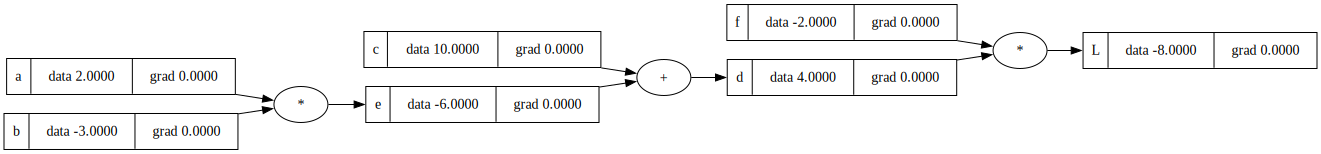

In [26]:
draw_dot(L)

### Chain Rule

dL/df = delta L / ((f+h)-f)

dL/dc = dL/df * df/dc

'+' : derivative 1

'*' : derivative other node value



In [27]:
#dL/dd
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

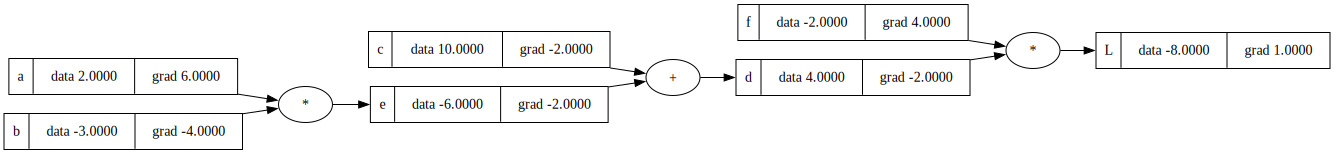

In [28]:
draw_dot(L)

In [29]:
# forward pass
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [30]:
f.data, f.grad

(-1.96, 4.0)

In [31]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data


    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    # c.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-3.9999999999995595


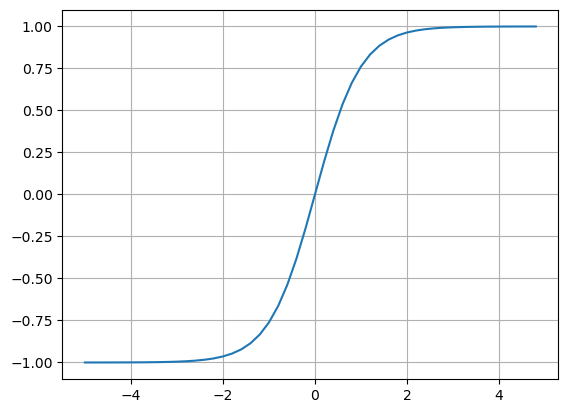

In [32]:
# tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [74]:
# backpropagation

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


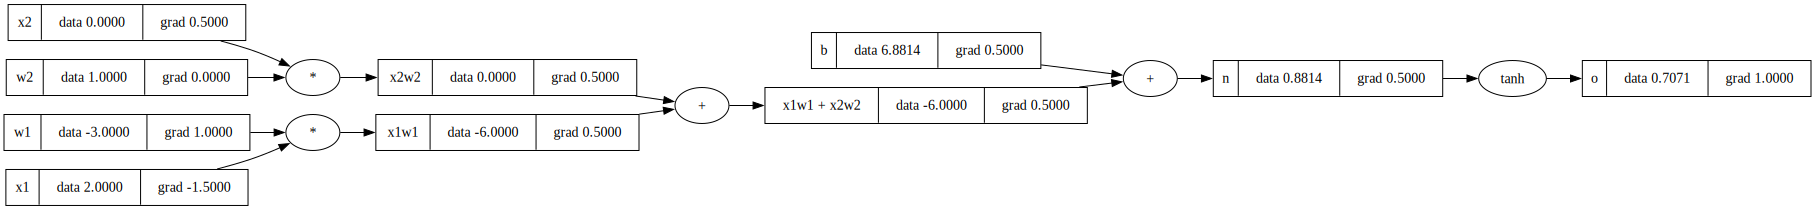

In [75]:
draw_dot(o)

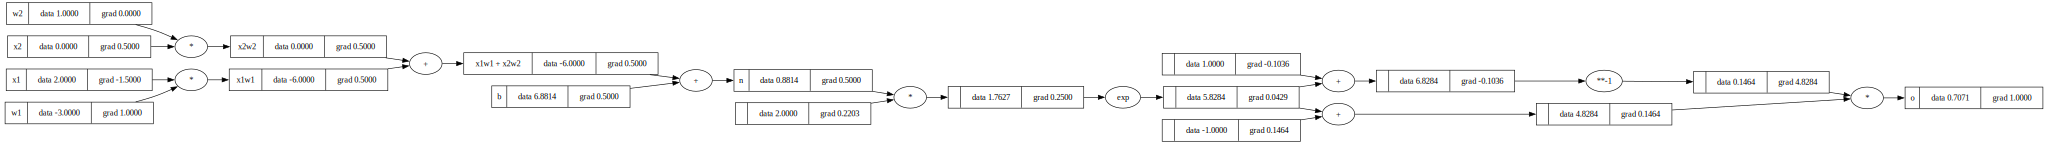

In [77]:
# backpropagation -- tanh broken down into (e^2x - 1)/(e^2x + 1)

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.    , label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#---
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [78]:
import torch

In [94]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())



0.7071066904050358
----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [99]:
o.data.item()

0.7071066904050358

In [102]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [81]:
x1.double()

tensor([2.], dtype=torch.float64)

In [87]:
torch.Tensor([[1., 2., 3.], [4,5,6]]).dtype

torch.float32

### Neural Network similar to PyTorch

In [105]:
import random

In [275]:
class Neuron:

    # create and init a neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    # calculate output given input x
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    # create/initialize required number of input and next layer neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP:
    "Defines multilayer neural network"

    def __init__(self, nin, nouts): # ex: 3, [3,4,5]
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # output of ith layer is input of (i+1)th layer
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [276]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9990146134897147, grad=0.0)

In [277]:
lay = Layer(3,6)

In [278]:
lay([2.0, 3.1, 4.9])

[Value(data=-0.9989212337583633, grad=0.0),
 Value(data=-0.9999999441622347, grad=0.0),
 Value(data=0.9999776278094787, grad=0.0),
 Value(data=-0.9999917463476099, grad=0.0),
 Value(data=-0.999883427050781, grad=0.0),
 Value(data=0.9992467983321135, grad=0.0)]

In [369]:
mlp = MLP(3, [4, 4, 1])
mlp([2.0, 3.1, 4.9])

Value(data=0.04305851937597354, grad=0.0)

In [370]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [378]:
for k in range(200):
    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += -0.1 * p.grad # minus to minize the loss

    print(k, loss.data)

0 0.0003026052097972934
1 0.0003021088393539005
2 0.0003016140498800962
3 0.0003011208339192118
4 0.0003006291840611401
5 0.000300139092941958
6 0.0002996505532436002
7 0.0002991635576934613
8 0.0002986780990640791
9 0.0002981941701727743
10 0.0002977117638813065
11 0.00029723087309553245
12 0.00029675149076504215
13 0.0002962736098828834
14 0.0002957972234851528
15 0.0002953223246507429
16 0.0002948489065009423
17 0.00029437696219916784
18 0.0002939064849506125
19 0.00029343746800195725
20 0.00029296990464100666
21 0.0002925037881964265
22 0.0002920391120374147
23 0.0002915758695733967
24 0.0002911140542536994
25 0.00029065365956729904
26 0.0002901946790424743
27 0.0002897371062465414
28 0.0002892809347855495
29 0.0002888261583039992
30 0.000288372770484529
31 0.00028792076504767007
32 0.00028747013575152147
33 0.00028702087639151575
34 0.00028657298080009936
35 0.0002861264428464817
36 0.0002856812564363494
37 0.0002852374155116091
38 0.0002847949140501203
39 0.00028435374606541034
4

In [379]:
ypred

[Value(data=0.9930567623750731, grad=-0.013886475249853758),
 Value(data=-0.9967041360248287, grad=0.006591727950342685),
 Value(data=-0.99141830717472, grad=0.01716338565055997),
 Value(data=0.9902596335289015, grad=-0.0194807329421971)]

[Value(data=0.999999594980157, grad=0.0),
 Value(data=-0.999999999999996, grad=0.0),
 Value(data=-0.9999999999999987, grad=0.0),
 Value(data=0.9999998259555527, grad=0.0)]

In [297]:
mlp.layers[0].neurons[0].w

[Value(data=0.7969639178093085, grad=0.8757135974674767),
 Value(data=-0.680787628607632, grad=1.1017626775703304),
 Value(data=0.6620061793249495, grad=-0.6404286988800311)]

In [260]:
# draw_dot(loss)

In [284]:
len(mlp.parameters())

41

In [285]:
mlp.parameters()

[Value(data=0.812108767610008, grad=0.07373372413923175),
 Value(data=-0.6615970207925193, grad=0.09559890883705274),
 Value(data=0.6513174731673232, grad=-0.04586760977335478),
 Value(data=0.38693998599123836, grad=0.0628154104252849),
 Value(data=0.9640704865177228, grad=0.059841434732284586),
 Value(data=0.9819301028118552, grad=0.029607470412827998),
 Value(data=0.592061522438404, grad=0.08116892070922238),
 Value(data=-0.7337906222331634, grad=0.05962303676220558),
 Value(data=0.904550493363343, grad=-0.050672481491337344),
 Value(data=0.6607125591605396, grad=0.05264820594352489),
 Value(data=-0.7787620904674522, grad=0.017989442467918636),
 Value(data=0.5903714710416805, grad=0.008425320048479075),
 Value(data=0.3976446221573364, grad=0.4161571911726922),
 Value(data=-0.5249096883807456, grad=-0.3841786494609366),
 Value(data=-0.9604740416148769, grad=0.24089231587088356),
 Value(data=-0.2805303387465614, grad=0.12030933277106501),
 Value(data=0.37451459246628604, grad=0.3305142